# Set up 

## Check Environment 

In [38]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [39]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [40]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

In [42]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"

In [43]:
%store s3_public_path

Stored 's3_public_path' (str)


In [44]:
s3_private_path = "s3://{}/gunData".format(bucket)
s3_private_path

's3://sagemaker-us-east-1-898900188658/gunData'

In [45]:
%store s3_private_path

Stored 's3_private_path' (str)


In [46]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/sub_est2018_all.csv to s3://sagemaker-us-east-1-898900188658/gunData/sub_est2018_all.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-898900188658/gunData/gun_violence.csv


# Create Database Schema in Athena

In [47]:
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = '{}/gunData'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-898900188658/gunData'

In [48]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [49]:
#assign database name
database_name = "ads508"

In [50]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [51]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [52]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [53]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws


## Create Athena Table

In [54]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-898900188658/gunData


In [55]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [56]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-898900188658/gunData/census2010_data


In [57]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [58]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,est2018
1,gun_violence


In [59]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district


In [60]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018


# Insert Dataset into Pandas Dataframe

In [61]:
df = pd.read_csv("{}/gun_violence.csv".format(s3_path))
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


# Feature Engineering

In [62]:
### Parse gun_type column and display histogram of gun type frequency

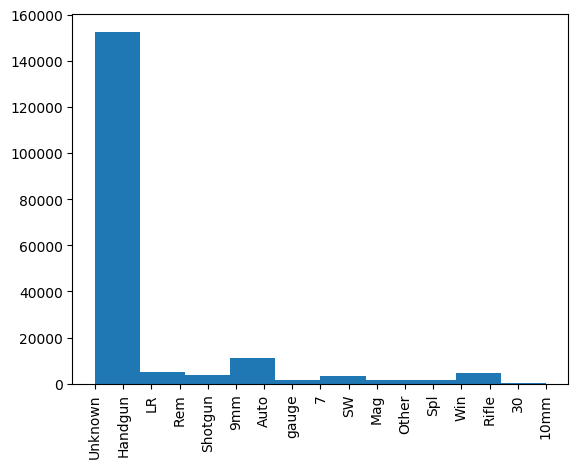

In [63]:
###############
# Gun Type
###############
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

In [64]:
### Create 'zipcode' column based on geographic coordinates

In [65]:
!pip install geopy
import geopy
import pandas as pd

geolocator = geopy.Nominatim(user_agent="check_1")

def get_zip_code(x):
    location = geolocator.reverse("{}, {}".format(x['latitude'],x['longitude']))
    return location.raw['address']['postcode']

df['zipcode'] = df.head().apply(lambda x: get_zip_code(x), axis = 1)

In [66]:
### New 'suspect_count' and 'victim_count' columns per incident

In [67]:
participant_type = df['participant_type']

i = 0

for parts in participant_type:

    suspects = []
    victims = []

    if '||' in str(parts):
        part = str(parts).split('||')
        for keyval in part:
            if '::' in str(keyval):
                part_value = str(keyval).split('::')
                if part_value[1] == 'Victim':
                    victims.append(part_value[1])
                elif part_value[1] == 'Subject-Suspect':
                    suspects.append(part_value[1])

    df.at[i,'victim_count'] = len(victims)
    df.at[i,'suspect_count'] = len(suspects)
    i = i + 1

In [68]:
### New Suspect Age Group Column

In [69]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

df['suspect_age'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age_group']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        df.at[i, 'suspect_age'] = element[0]
                    else:
                        df.at[i, 'suspect_age'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


In [70]:
### New Suspect Age Column

In [71]:
df['suspect_age_value'] = ''
df[['suspect_age_value']] = df[['suspect_age_value']].apply(pd.to_numeric)

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            pass
                            #print("empty element: --%s--" % element[0])
                        else:
                            df.at[i, 'suspect_age_value'] = int(element[0])
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            df.at[i, 'suspect_age_value'] = int(match_age[0])
                        #print("i = %d" % i)
                else:
                    continue



In [72]:
### Create Suspect Gender Column

# 'Gender Unknown' can mean two things:
# 1: There was a suspect but the gender was not recorded in the dataset
# 2: There was no suspect in the incident

In [74]:
def has_numbers(inputString):
    if inputString != 'Male' and inputString != 'Female':
        #print("stop here")
        pass

    #print(type(inputString))
    for char in inputString:
        result = char.isdigit()
        if(result == True):
            return result
    #return any(char.isdigit() for char in inputString)
    
print("size of dataframe at start: %d" % len(df))

df['suspect_gender'] = ''
df[['suspect_gender']] = df[['suspect_gender']].apply(str)
# 0 = male
# 1 = female

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_gender row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_gender']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        else:
                            if has_numbers(element[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = element[0]
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            if has_numbers(match_age[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue




for i,row in df.iterrows():
    result = row['suspect_gender']
    if result != 'Female' and result != 'Male':
        df.at[i, 'suspect_gender'] = 'Gender Unknown'

size of dataframe at start: 239677


In [75]:
print(df.columns)

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'zipcode', 'victim_count', 'suspect_count',
       'suspect_age', 'suspect_age_value', 'suspect_gender'],
      dtype='object')


In [76]:
print(df.head(5))

   incident_id        date           state city_or_county  \
0       461105  2013-01-01    Pennsylvania     Mckeesport   
1       460726  2013-01-01      California      Hawthorne   
2       478855  2013-01-01            Ohio         Lorain   
3       478925  2013-01-05        Colorado         Aurora   
4       478959  2013-01-07  North Carolina     Greensboro   

                                     address  n_killed  n_injured  \
0  1506 Versailles Avenue and Coursin Street         0          4   
1               13500 block of Cerise Avenue         1          3   
2                      1776 East 28th Street         1          3   
3           16000 block of East Ithaca Place         4          0   
4                  307 Mourning Dove Terrace         2          2   

                                        incident_url  \
0  http://www.gunviolencearchive.org/incident/461105   
1  http://www.gunviolencearchive.org/incident/460726   
2  http://www.gunviolencearchive.org/incident/4788